In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from math import sqrt
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn
seaborn.set()

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

In [2]:
def read_csv(directory_name , fileName):
    '''
    Read the file from a directory given directory name and file name, we collected all the data in one directory 
    '''
    read_file = 'sensor data/' + directory_name + '/' + fileName + '.csv'
    df = pd.read_csv(read_file)                                           # Create a DataFrame for return value 
    del df['Unnamed: 7']                                                  # delete unknown columns to make DataFrame clean  
    df = df[ (df['time'] >= 3) & (df['time'] <= 6) ]                      # Only included time from 5s to 15s
    df['aT'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)           # get total acceleration
    return df                                                             # return the DataFrame

In [3]:
#read_csv('sensor data' , '上楼梯口袋1')

In [4]:
def Butterworth_filter(data):
    '''
    Low-pass: keep the low frequencies; discard the high.
    High-pass: keep the high frequencies; discard the low.
    '''
    b, a = signal.butter(3, 0.05, btype = 'lowpass', analog = False)
    low_passed = signal.filtfilt(b, a, data)
    return low_passed


def Butterworth_filter_forplot(data):
    '''
    Given a dataFrame , apply Butterworth filter for each column 
    '''
    data = data.apply(Butterworth_filter , axis = 0)
    return data

In [5]:
# citation: https://github.com/philip-L/CMPT353-1/blob/master/analysis2.py
# Figure out what happening here, write our own FFT function and report must mention why we do this 
def Butterworth_filter_and_FFT(data):
    # Using the Butterworth filter
    data_bw = data.apply(Butterworth_filter , axis = 0)
    data_bw = data_bw.reset_index(drop = True)
    # del data_bw['time']
    data = data.reset_index(drop = True)
    # FFT of the data after the Butterworth filter
    data_FT = data_bw.apply(np.fft.fft , axis = 0)      
    data_FT = data_FT.apply(np.fft.fftshift , axis = 0)
    data_FT = data_FT.abs()
    
    # Determine the sampling frequency
    Fs = round(len(data) / data.at[len(data)-1, 'time']) #samples per second
    data_FT['freq'] = np.linspace(-Fs/2, Fs/2, num = len(data))
    
    # Find the largest peak at a frequency greater than 0 to determine the average steps per second
    temp_FT = data_FT[data_FT['freq'] > 0.1]
    ind = temp_FT['aT'].nlargest(n = 1)
    max_ind = ind.idxmax()
    avg_freq = data_FT.at[max_ind , 'freq']
    
    #Transform the data to fit a normal distribution
    max_val = data_FT['aT'].nlargest(n = 1)
    max_val_ind = max_val.idxmax()
    data_FT.at[max_val_ind , 'aT'] = temp_FT['aT'].max()
    
    return data_FT , avg_freq

In [6]:
#Butterworth_filter_and_FFT(read_csv('walk_hold' , 'walk_hold2'))

In [7]:
def plot_acceleration_FFT(data_FT):
    plt.figure(figsize = (20, 15))
    plt.plot(data_FT['freq'] , data_FT['aT'] , 'r-' , alpha = 0.5)
    plt.title("FFT for total acceleration")

In [8]:
#Butterworth_filter_and_FFT(read_csv('walk_hold' , 'walk_hold2'))
#plot_acceleration_FFT(Butterworth_filter_and_FFT(read_csv('walk_hold' , 'walk_hold2')))

In [9]:
def plot_acceleration(data):
    '''
    General function for plot the accleration. Subplot 4 graph, x axis y axis z axis and total accleration
    '''
    plt.figure(figsize = (30, 10))
    plt.subplot(4 , 1 , 1)
    plt.plot(data['time'] , data['ax'] , 'r.' , alpha = 0.5)
    plt.title('X axis acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')
    plt.subplot(4 , 1 , 2)
    plt.plot(data['time'] , data['ay'] , 'g.' , alpha = 0.5)
    plt.title('Y axis acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')
    plt.subplot(4 , 1 , 3)
    plt.plot(data['time'] , data['az'] , 'b.' , alpha = 0.5)
    plt.title('Z axis acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')
    plt.subplot(4 , 1 , 4)
    plt.plot(data['time'] , data['aT'] , 'k.' , alpha = 0.5)
    plt.title('Total acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')

In [29]:
def plot_initial_try(data):
    '''
    General function for plot the accleration. Subplot 4 graph, x axis y axis z axis and total accleration
    '''
    plt.figure(figsize = (20, 10))
    plt.subplot(4 , 1 , 1)
    plt.plot(data['time'] , data['gFx'] , 'r.' , alpha = 0.5)
    plt.title('X axis')
    plt.xlabel('Time(s)')
    plt.subplot(4 , 1 , 2)
    plt.plot(data['time'] , data['gFy'] , 'g.' , alpha = 0.5)
    plt.title('Y axis')
    plt.xlabel('Time(s)')
    plt.subplot(4 , 1 , 3)
    plt.plot(data['time'] , data['gFz'] , 'b.' , alpha = 0.5)
    plt.title('Z axis')
    plt.xlabel('Time(s)')
    plt.subplot(4 , 1 , 4)
    plt.plot(data['time'] , data['I'] , 'k.' , alpha = 0.5)
    plt.title('Light-meter')
    plt.xlabel('Time(s)')

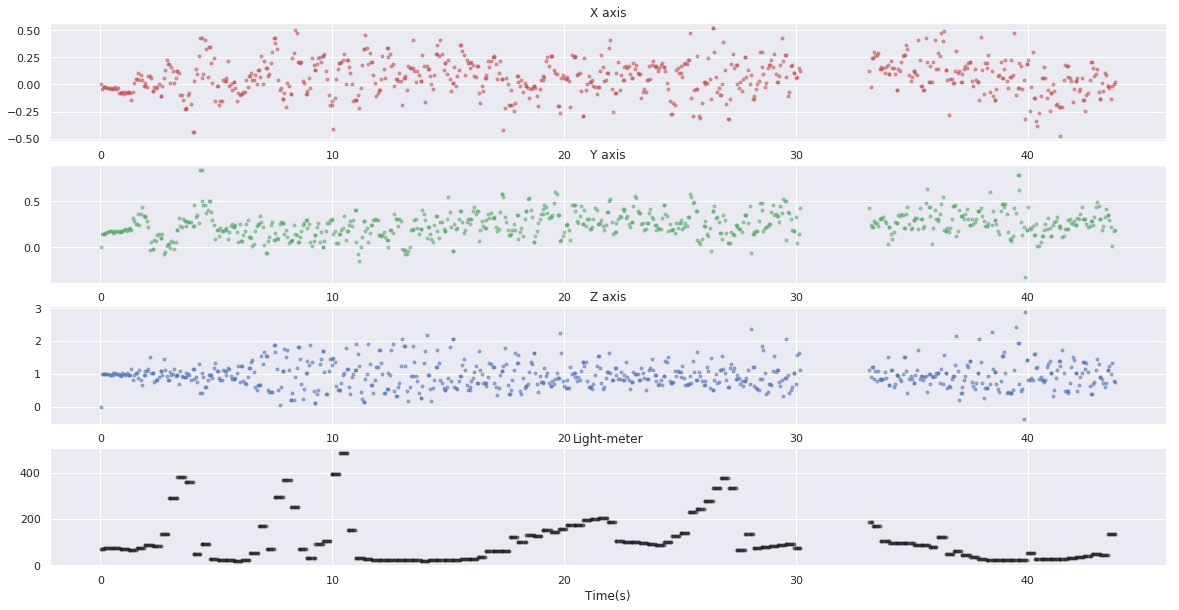

In [30]:
#plot_acceleration(Butterworth_filter_forplot(read_csv('downstairs_hold' , 'downstairs_hold10')))
#plot_acceleration(read_csv('downstairs_hold' , 'downstairs_hold10'))
plot_initial_try(pd.read_csv('walk_double_outp.csv'))

In [12]:
#plot_acceleration(Butterworth_filter_forplot(read_csv('sensor data' , '上楼梯手持8')))

In [13]:
def plot_gyroscope(data):
    '''
    General function for plot the Gyroscope. Subplot 3 graph, x axis y axis z axis
    '''
    plt.figure(figsize = (20, 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(data['time'] , data['wx'] , 'r.' , alpha = 0.5)
    plt.title('X axis gyroscope')
    plt.xlabel('Time(s)')
    plt.ylabel('Gyroscope(rad/s)')
    plt.subplot(3 , 1 , 2)
    plt.plot(data['time'] , data['wy'] , 'g.' , alpha = 0.5)
    plt.title('Y axis gyroscope')
    plt.xlabel('Time(s)')
    plt.ylabel('Gyroscope(rad/s)')
    plt.subplot(3 , 1 , 3)
    plt.plot(data['time'] , data['wz'] , 'b.' , alpha = 0.5)
    plt.title('Z axis gyroscope')
    plt.xlabel('Time(s)')
    plt.ylabel('Gyroscope(rad/s)')

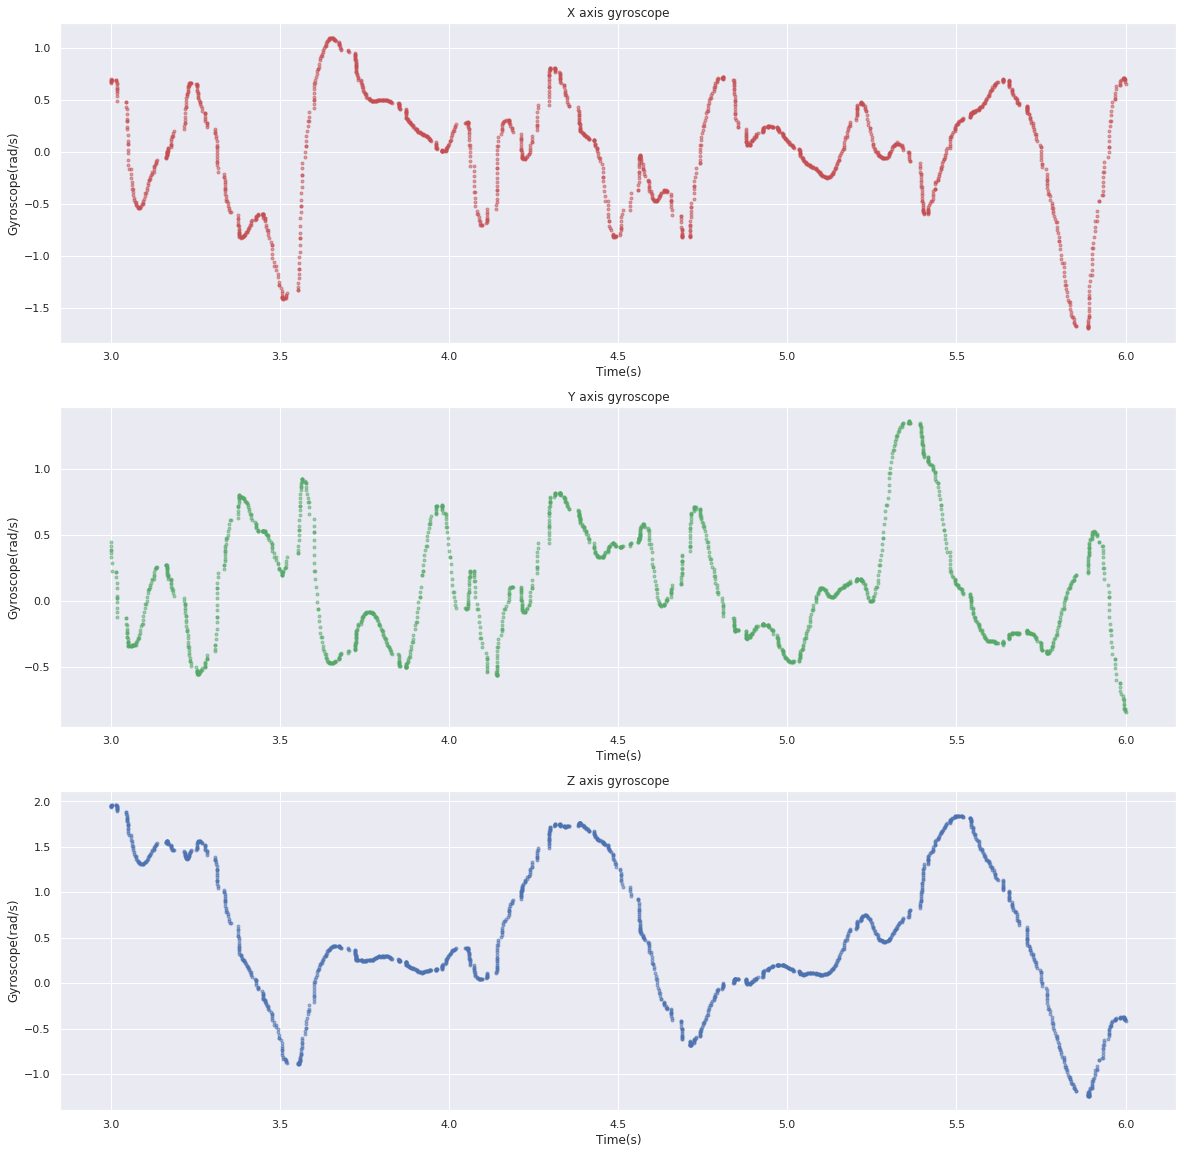

In [14]:
#plot_gyroscope(Butterworth_filter_forplot(read_csv('walk_hold' , 'walk_hold10')))
plot_gyroscope(read_csv('walk_hold' , 'walk_hold10'))

In [15]:
def get_basic_feature(data):
    # The parameter will be the original dataFrame after some data cleaning
    '''
    ax , ay , az , wx , wy , wz , aT
    mean        0.379203
    std         2.659466
    min       -11.236750
    25%        -0.963552
    50%         0.422153
    75%         1.849594
    max         9.068970
    Get the basic statistical feature for each direction of acceleration and gyrpscope
    .describe will give us mean, std, min, 25%, 50%, 75%, max value. All of these are basic feature we need give it to Machine Learning
    '''
    stat_summary = []
    ax_stat_summary = data['ax'].describe()      # .describe get the basic feature 
    for i in range(1 , 8):
        stat_summary.append(ax_stat_summary[i])  # each feature append it to the list  
    ay_stat_summary = data['ay'].describe()
    for i in range(1 , 8):
        stat_summary.append(ay_stat_summary[i])
    az_stat_summary = data['az'].describe()
    for i in range(1 , 8):
        stat_summary.append(az_stat_summary[i]) 
    wx_stat_summary = data['wx'].describe()
    for i in range(1 , 8):
        stat_summary.append(wx_stat_summary[i]) 
    wy_stat_summary = data['wy'].describe()
    for i in range(1 , 8):
        stat_summary.append(wy_stat_summary[i]) 
    wz_stat_summary = data['wz'].describe()
    for i in range(1 , 8):
        stat_summary.append(wz_stat_summary[i]) 
    aT_stat_summary = data['aT'].describe()
    for i in range(1 , 8):
        stat_summary.append(aT_stat_summary[i]) 

    return stat_summary # return a large list that given a dataFrame, return all the basic feature

In [16]:
#get_basic_feature(Butterworth_filter_forplot(read_csv('sensor data' , '上楼梯口袋1')))

In [17]:
def get_acceleration_slope_max(data_col):
    data_shift = data_col.shift(periods = -1 , fill_value = 0)
    data_difference = abs(data_col - data_shift) 
    data_slope = abs(data_difference / data_col)
    data_slope = data_slope[:-1]
    return data_slope.max()

In [18]:
#get_acceleration_slope_max(Butterworth_filter_forplot(read_csv('sensor data' , '走路口袋10'))['aT'])

In [19]:
def get_basic_feature_butterworth(data):
    data_bw = Butterworth_filter_forplot(data)
    data_feature = get_basic_feature(data_bw)
    '''
    ax_slope_max = get_acceleration_slope_max(data['ax'])
    ay_slope_max = get_acceleration_slope_max(data['ay'])
    az_slope_max = get_acceleration_slope_max(data['az'])
    wx_slope_max = get_acceleration_slope_max(data['wx'])
    wy_slope_max = get_acceleration_slope_max(data['wy'])
    wz_slope_max = get_acceleration_slope_max(data['wz'])
    aT_slope_max = get_acceleration_slope_max(data['aT'])

    data_feature.append(ax_slope_max)
    data_feature.append(ay_slope_max)
    data_feature.append(az_slope_max)
    data_feature.append(wx_slope_max)
    data_feature.append(wy_slope_max)
    data_feature.append(wz_slope_max)
    data_feature.append(aT_slope_max)
    '''
    return data_feature

In [20]:
def get_feature_dataFrame():
    feature_list = []
    for i in range(1 , 16):
        data = read_csv('downstairs_hold' , 'downstairs_hold' + str(i))
        data_feature = get_basic_feature_butterworth(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])     
        data_feature.append('downstairs_hold')
        feature_list.append(data_feature)

    for i in range(1 , 16):
        data = read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i))
        data_feature = get_basic_feature_butterworth(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('downstairs_inpocket')
        feature_list.append(data_feature)

    for i in range(1 , 16):
        data = read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i))
        data_feature = get_basic_feature_butterworth(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('unstairs_inpocket')
        feature_list.append(data_feature)

    for i in range(1 , 16):
        data = read_csv('upstairs_hold' , 'upstairs_hold' + str(i))
        data_feature = get_basic_feature_butterworth(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('upstairs_hold')
        feature_list.append(data_feature)

    for i in range(1 , 16):
        data = read_csv('walk_hold' , 'walk_hold' + str(i))
        data_feature = get_basic_feature_butterworth(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('walk_hold')
        feature_list.append(data_feature)

    for i in range(1 , 16):
        data = read_csv('walk_inpocket' , 'walk_inpocket' + str(i))
        data_feature = get_basic_feature_butterworth(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('walk_inpocket')
        feature_list.append(data_feature)

    for i in range(1 , 16):
        data = read_csv('falldown_hold' , 'falldown_hold' + str(i))
        data_feature = get_basic_feature(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('falldown_hold')
        feature_list.append(data_feature)  
        
    for i in range(1 , 16):
        data = read_csv('falldown_inpocket' , 'falldown_inpocket' + str(i))
        data_feature = get_basic_feature(data)
        data_feature.append(Butterworth_filter_and_FFT(data)[1])  
        data_feature.append('falldown_inpocket')
        feature_list.append(data_feature)  
        

    '''
    ax , ay , az , wx , wy , wz , aT
    mean        0.379203
    std         2.659466
    min       -11.236750
    25%        -0.963552
    50%         0.422153
    75%         1.849594
    max         9.068970
    '''
    '''
    'ax_slope_max' , 'ay_slope_max' , 'az_slope_max' , 'wx_slope_max' , 'wy_slope_max' , 
                   'wz_slope_max' , 'aT_slope_max' , 'catogary'
    '''
    column_name = ['ax_mean' , 'ax_std' , 'ax_min' , 'ax_25' , 'ax_50' , 'ax_75' , 'ax_max',
                   'ay_mean' , 'ay_std' , 'ay_min' , 'ay_25' , 'ay_50' , 'ay_75' , 'ay_max',
                   'az_mean' , 'az_std' , 'az_min' , 'az_25' , 'az_50' , 'az_75' , 'az_max',
                   'wx_mean' , 'wx_std' , 'wx_min' , 'wx_25' , 'wx_50' , 'wx_75' , 'wx_max',
                   'wy_mean' , 'wy_std' , 'wy_min' , 'wy_25' , 'wy_50' , 'wy_75' , 'wy_max',
                   'wz_mean' , 'wz_std' , 'wz_min' , 'wz_25' , 'wz_50' , 'wz_75' , 'wz_max',
                   'aT_mean' , 'aT_std' , 'aT_min' , 'aT_25' , 'aT_50' , 'aT_75' , 'aT_max',
                   'avg_freq' , 'catogary']
    df = pd.DataFrame(feature_list , columns = column_name)
    df.to_csv('feature_df.csv' , index = False)
    return df

In [21]:
def get_X():
    X = []
    for i in range(1 , 16):
        X.append(get_basic_feature_butterworth(read_csv('downstairs_hold' , 'downstairs_hold' + str(i))))
        X.append(get_basic_feature_butterworth(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i))))
        X.append(get_basic_feature_butterworth(read_csv('upstairs_hold' , 'upstairs_hold' + str(i))))      
        X.append(get_basic_feature_butterworth(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i))))
        X.append(get_basic_feature_butterworth(read_csv('walk_hold' , 'walk_hold' + str(i))))
        X.append(get_basic_feature_butterworth(read_csv('walk_inpocket' , 'walk_inpocket' + str(i))))
        X.append(get_basic_feature_butterworth(read_csv('falldown_hold' , 'falldown_hold' + str(i))))
        X.append(get_basic_feature_butterworth(read_csv('falldown_inpocket' , 'falldown_inpocket' + str(i))))
    return X    


def get_y():
    y = []
    for i in range(1, 16):
        y.append('downstairs_hold')
        y.append('downstairs_inpocket')
        y.append('upstairs_hold')
        y.append('upstairs_inpocket')
        y.append('walk_hold')
        y.append('walk_inpocket')
        y.append('falldown_hold')
        y.append('falldown_inpocket')
    return y

In [22]:
get_feature_dataFrame()

,ax_mean,ax_std,ax_min,ax_25,ax_50,ax_75,ax_max,ay_mean,ay_std,ay_min,ay_25,ay_50,ay_75,ay_max,az_mean,az_std,az_min,az_25,az_50,az_75,az_max,wx_mean,wx_std,wx_min,wx_25,wx_50,wx_75,wx_max,wy_mean,wy_std,wy_min,wy_25,wy_50,wy_75,wy_max,wz_mean,wz_std,wz_min,wz_25,wz_50,wz_75,wz_max,aT_mean,aT_std,aT_min,aT_25,aT_50,aT_75,aT_max,avg_freq,catogary
0,0.445680,1.274369,-2.615458,-0.326385,0.356382,1.138927,5.532318,-0.433846,0.923380,-1.909014,-1.149225,-0.488073,0.066145,2.507598,-0.070659,4.670560,-6.855642,-3.998286,-1.185706,2.908548,12.041949,0.006224,0.652192,-1.464425,-0.401411,0.171322,0.487627,1.560742,0.001163,0.491089,-1.649041,-0.309059,-0.044378,0.275412,1.860719,-0.123931,0.520659,-1.618229,-0.447279,-0.033407,0.314864,0.704034,4.263630,2.559509,0.271630,2.085799,3.908049,5.765097,12.542782,1.924175,downstairs_hold
1,0.081400,1.185456,-2.833387,-0.758618,-0.037339,1.012107,3.463497,-0.345666,0.914411,-1.968227,-1.076383,-0.377417,0.113231,2.513043,0.370069,4.562895,-7.389209,-3.417337,-0.530764,3.821364,11.831661,-0.021442,0.761735,-2.017862,-0.473927,0.018157,0.446499,2.972124,-0.016034,0.720974,-3.274859,-0.365134,0.058128,0.402574,1.473070,-0.078848,0.490188,-1.652239,-0.362312,0.020069,0.304989,0.583965,4.207336,2.384871,0.368095,2.410174,3.901627,5.254403,11.985914,1.919856,downstairs_hold
2,0.268030,1.118460,-2.366547,-0.501634,0.216712,0.899177,3.871785,-0.152500,0.802338,-1.734614,-0.637721,-0.291940,0.467827,2.359096,0.341170,3.065541,-5.577880,-1.952174,0.144422,1.916576,8.396274,-0.075343,0.754758,-2.109781,-0.423317,-0.121517,0.432667,1.630831,-0.149861,0.541015,-2.161972,-0.378767,-0.158458,0.106471,1.591992,-0.381469,0.562936,-1.759046,-0.740559,-0.365380,-0.019856,0.814705,2.928365,1.732376,0.616421,1.621606,2.426673,3.920709,8.780948,1.002220,downstairs_hold
3,0.171151,1.244461,-3.383385,-0.528601,0.173797,0.750718,3.770956,-0.359943,0.923297,-2.029892,-1.035643,-0.407928,0.226654,2.362434,0.385021,3.771830,-7.608135,-2.078960,-0.258047,2.762963,11.964867,-0.003673,0.795274,-2.223383,-0.479631,0.088764,0.525155,2.082652,-0.131772,0.580844,-2.176026,-0.380340,-0.060449,0.196539,1.178380,-0.376657,0.658194,-3.218577,-0.586746,-0.257589,-0.028464,0.635917,3.551029,2.098668,0.914651,2.017149,3.035755,4.499007,12.100027,1.087549,downstairs_hold
4,0.363184,1.334209,-2.262021,-0.553972,0.327087,1.115372,6.434166,-0.425974,0.917237,-2.274120,-0.937490,-0.508711,0.083198,3.560879,0.266011,3.752425,-6.787432,-2.637001,-0.789437,2.792597,11.685971,-0.040848,0.738134,-2.566398,-0.480161,0.044739,0.415943,1.457185,-0.142907,0.634558,-1.946621,-0.416083,-0.123715,0.136903,3.321737,-0.310569,0.724038,-1.848075,-0.792119,-0.286084,0.229273,0.971105,3.572835,2.110442,0.401516,2.261952,3.216975,4.143697,12.430283,2.082177,downstairs_hold
5,-0.147397,1.212359,-2.314723,-1.092326,-0.308715,0.625922,3.113497,-0.226470,0.880737,-2.676962,-0.726177,-0.152570,0.370801,1.794404,-0.088409,4.794072,-7.782926,-4.105267,-0.853132,2.844377,11.015353,-0.004182,0.746599,-1.864965,-0.476314,0.150434,0.510865,1.255063,-0.020584,0.412300,-1.118184,-0.283575,0.015873,0.224720,1.079026,0.050923,0.488388,-1.146003,-0.278625,0.113137,0.382406,1.357253,4.394816,2.446370,0.460943,2.322962,4.143684,5.732244,11.131085,1.831299,downstairs_hold
6,0.096077,1.344546,-2.359599,-1.042820,0.075222,1.108224,3.704907,-0.257541,1.001592,-2.809289,-0.875773,-0.123204,0.341388,2.449919,0.053786,4.625797,-8.191747,-3.791116,-1.596234,4.037322,11.837721,0.057677,0.808833,-1.989063,-0.341613,0.213764,0.636940,2.350420,0.021322,0.486608,-1.926279,-0.276411,0.077455,0.384414,1.029912,-0.058670,0.742122,-1.665645,-0.712979,0.053816,0.576889,1.327853,4.461378,2.104315,0.746943,2.988373,4.209799,5.597173,11.980971,2.002225,downstairs_hold
7,0.059458,1.297983,-3.490478,-0.708458,0.110006,0.794362,3.733134,-0.340616,0.892724,-2.997625,-0.871821,-0.306737,0.206037,1.872761,0.100229,3.964336,-6.498487,-3.075502,-0.387758,2.748250,12.617232,0.024577,0.774012,-2.224214

In [23]:
def build_test_data(directory_name , fileName):
    '''
    Some time we don't just want the predict score, we want to know given an input data, what will the Machine Learning
    exactly give us. So this piece of code is build the test data. Also we collect some test data. 
    '''
    test_data = pd.read_csv(directory_name + '/' + fileName + '.csv')
    
    del test_data['Unnamed: 7']                                                             # Delete unknown columns to make DataFrame clean  
    test_data = test_data[ (test_data['time'] >= 3) & (test_data['time'] <= 6) ]            # Only included time from 5s to 15s
    test_data['aT'] = np.sqrt(test_data['ax']**2 + test_data['ay']**2 + test_data['az']**2) # Get total acceleration
    feature_list = []
    feature = get_basic_feature(test_data)
    feature_list.append(feature)
    column_name = ['ax_mean' , 'ax_std' , 'ax_min' , 'ax_25' , 'ax_50' , 'ax_75' , 'ax_max',
               'ay_mean' , 'ay_std' , 'ay_min' , 'ay_25' , 'ay_50' , 'ay_75' , 'ay_max',
               'az_mean' , 'az_std' , 'az_min' , 'az_25' , 'az_50' , 'az_75' , 'az_max',
               'wx_mean' , 'wx_std' , 'wx_min' , 'wx_25' , 'wx_50' , 'wx_75' , 'wx_max',
               'wy_mean' , 'wy_std' , 'wy_min' , 'wy_25' , 'wy_50' , 'wy_75' , 'wy_max',
               'wz_mean' , 'wz_std' , 'wz_min' , 'wz_25' , 'wz_50' , 'wz_75' , 'wz_max',
               'aT_mean' , 'aT_std' , 'aT_min' , 'aT_25' , 'aT_50' , 'aT_75' , 'aT_max',]
               
    return feature_list

In [24]:
#build_test_data('Test predict data' , 'downstairs_hold_test')

In [25]:
def FFT_normaltest():
    for i in range(1 , 16):
        data = read_csv('downstairs_hold' , 'downstairs_hold' + str(i))
        data_FFT = Butterworth_filter_and_FFT(data)
        data_FFT_pvalue = stats.normaltest(data_FFT['aT']).pvalue
        if (data_FFT_pvalue <= 0.05):
            print('downstairs_hold' + str(i) , "is not normal" , "pvalue:" , data_FFT_pvalue)
        else:
            print('downstairs_hold' + str(i) , "is normal" , "pvalue:" , data_FFT_pvalue)
            
        data = read_csv('upstairs_hold' , 'upstairs_hold' + str(i))
        data_FFT = Butterworth_filter_and_FFT(data)
        data_FFT_pvalue = stats.normaltest(data_FFT['aT']).pvalue
        if (data_FFT_pvalue <= 0.05):
            print('upstairs_hold' + str(i) , "is not normal" , "pvalue:" , data_FFT_pvalue)
        else:
            print('upstairs_hold' + str(i) , "is normal" , "pvalue:" , data_FFT_pvalue)
            
        data = read_csv('walk_hold' , 'walk_hold' + str(i))
        data_FFT = Butterworth_filter_and_FFT(data)
        data_FFT_pvalue = stats.normaltest(data_FFT['aT']).pvalue
        if (data_FFT_pvalue <= 0.05):
            print('walk_hold' + str(i) , "is not normal" , "pvalue:" , data_FFT_pvalue)
        else:
            print('walk_hold' + str(i) , "is normal" , "pvalue:" , data_FFT_pvalue)

In [26]:
# FFT_normaltest()